In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
%matplotlib inline

# Multi-Class Classification

The One vs All Classification method uses some digits data provided in a Matlab file. I know I can load `.mat` files into python, but figured it might be easier to use the digits set built into `Scikit-Learn`.

In [2]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

### Visualizing the data

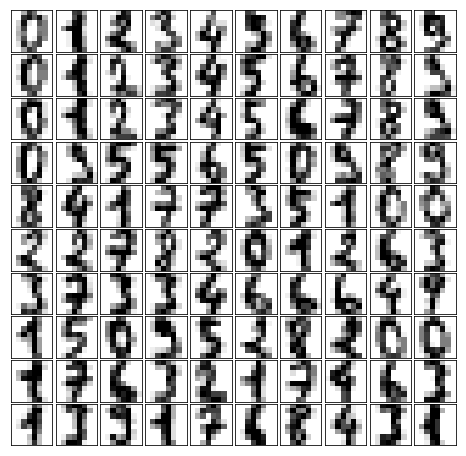

In [3]:
def plot_digits(data):
    fig, ax = plt.subplots(10, 10, figsize=(8, 8),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i].reshape(8, 8), cmap='binary')
        im.set_clim(0, 16)
plot_digits(digits.data)

## Vectorizing Logistic Regression

In [4]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

### Vectorizing the cost function

In [5]:
def cost(theta, X, y):
    theta = theta.reshape(-1, 1)      
    h = sigmoid(X.dot(theta))
    summation = np.sum(-y.T.dot(np.log(h)) - (1-y).T.dot(np.log(1-h)))
    return summation / X.shape[0]

### Vectorizing the gradient

In [6]:
def gradient(theta, X, y):
    theta = theta.reshape(-1, 1)      
    h = sigmoid(X.dot(theta))
    error = np.subtract(h,y)
    grad = X.T.dot(error) / X.shape[0]
    return grad

### Vectorizing regularized logistic regression

In [7]:
def costReg(theta, X, y, lam):
    theta = theta.reshape(-1, 1)  
    cost_func = cost(theta, X, y)
    reg_term = (lam/(2*X.shape[0])) * np.sum(theta[1:]**2)
    return cost_func + reg_term

In [8]:
def gradientReg(theta, X, y, lam):
    theta = theta.reshape(-1, 1)  
    grad = gradient(theta, X, y)

    reg_term = (lam/X.shape[0])*theta[1:]
    
    return np.append(grad[0],(grad[1:] + reg_term)).reshape(-1,1)

 ## One-vs-all Classification
 
In this part of the exercise, you will implement one-vs-all classification by training multiple regularized logistic regression classifiers, one for each of the $K$ classes in our dataset (Figure 1). In the handwritten digits dataset, $K = 10$, but your code should work for any value of $K$.

In [9]:
X = digits.data
y = digits.target

In [10]:
y.shape

(1797,)

In [11]:
from scipy.optimize import minimize

def one_vs_all(X, y, num_labels, learning_rate):
    rows = X.shape[0]
    params = X.shape[1]
    
    all_theta = np.zeros((num_labels, params + 1))
    
    X = np.insert(X, 0, values=np.ones(rows), axis=1)
    
    for i in range(1, num_labels + 1):
        theta = np.zeros(params + 1)
        y_i = np.array([1 if label == i else 0 for label in y])
        y_i = np.reshape(y_i, (rows, 1))
        
        fmin = minimize(fun=costReg, x0=theta, args=(X, y_i, learning_rate), method='TNC', jac=gradientReg)
        all_theta[i-1,:] = fmin.x
    
    return all_theta

In [12]:
rows = X.shape[0]
feautres = X.shape[1]

all_theta = np.zeros((10, feautres + 1))

X = np.insert(X, 0, values=np.ones(rows), axis=1)

theta = np.zeros(feautres + 1)

y_0 = np.array([1 if label == 0 else 0 for label in y])
y_0 = np.reshape(y_0, (rows, 1))

X.shape, y_0.shape, theta.shape, all_theta.shape

((1797, 65), (1797, 1), (65,), (10, 65))

These all appear to make sense.  Note that theta is a one-dimensional array, so when it gets converted to a matrix in the code that computes the gradient, it turns into a (1 X 401) matrix.  Let's also check the class labels in y to make sure they look like what we're expecting.

In [13]:
np.unique(y)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

Let's make sure that our training function actually runs, and we get some sensible outputs, before going any further.

In [14]:
all_theta = one_vs_all(X, y, 10, 1)

/home/nbuser/anaconda2_501/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log


We're now ready for the final step - using the trained classifiers to predict a label for each image.  For this step we're going to compute the class probability for each class, for each training instance (using vectorized code of course!) and assign the output class label as the class with the highest probability.

### One-vs-all Prediction

In [15]:
def predict_all(X, all_theta):
    rows = X.shape[0]
    params = X.shape[1]
    num_labels = all_theta.shape[0]
    
    # same as before, insert ones to match the shape
    X = np.insert(X, 0, values=np.ones(rows), axis=1)
    
    # convert to matrices
    X = np.matrix(X)
    all_theta = np.matrix(all_theta)
    
    h = sigmoid(X.dot(all_theta.T))
    
    h_argmax = np.argmax(h, axis=1)
    h_argmax = h_argmax+1
    
    return h_argmax

In [16]:
y_pred = predict_all(X, all_theta)

In [17]:
from sklearn.metrics import accuracy_score
accuracy_score(y, y_pred)

0.8970506399554814

## Alternative with SciKit-Learn

In [18]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC

In [19]:
y_pred = OneVsRestClassifier(LinearSVC(random_state=0)).fit(X, y).predict(X)

In [20]:
accuracy_score(y, y_pred)

0.991652754590985

## Neural Networks

I think the feed forward below should work, but I can't test it with the data I have, and I'm not going to load the `.mat` data at this point. The next exercise is all about neural networks, so I am going to move on to that one.

### Feedforward Propagation and Prediction

In [21]:
X = digits.data
y = digits.target

In [22]:
def forward_prop(theta,a1):
    a1 = np.insert(a1, 0, values=np.ones(rows), axis=1)

    # Do the first Linear step 
    z2 = theta[0].T.dot(a1.T)
    print(z2.shape)
    # Put it through the first activation function
    a2 = sigmoid(z2)
   
    # Second linear step
    z3 = a2.dot(theta[1])
    
    # Put through second activation function
    a3 = sigmoid(z3)
    h_argmax = np.argmax(a3, axis=1)
    h_argmax = h_argmax+1
    return h_argmax